In [7]:
import numpy as np
from math import sqrt
from skimage.transform import resize
import sys
import cv2
import numpy as np
import cv2
import glob
import random
from matplotlib.image import imsave
import mahotas as mh
from scipy import ndimage
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from itertools import islice
from IPython.display import display_html
from statsmodels.regression.linear_model import OLS as lm
from IPython.display import display, HTML
import pandas as pd
sns.set_style("white", {'axes.grid' : False})
%matplotlib inline
sns.set_style("white")
import warnings
warnings.filterwarnings('ignore')
random.seed(1337)

In [2]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)


In [3]:
def predict_areas(input_img,mu=False,no=False):
    labels, no_objects = ndimage.label(255-input_img)
    props=regionprops(labels) 
    size={i:props[i].area for i in range (0, no_objects)}
    areas=[float(i) * (0.64**2) for i in size.values() if float(i) * (0.64**2) >= 200 and float(i) * (0.64**2) <= 16000]
    no_of_cells=len(areas)
    if mu and no:
        return(areas,np.mean(areas),no_of_cells)
    elif mu:
        return(areas,np.mean(areas))
    else:
        return(areas)

In [4]:
def plot_me(img_list,x=5,y=5):
    i = 1
    fig = plt.figure(figsize=(20,25))
    for r in random.sample(img_list,len(img_list)):
        ax = fig.add_subplot(x,y,i)
        i+=1
        plt.imshow(plt.imread(r))
        plt.title('%s'%r.split('/')[2].split('_')[0])

In [5]:
import pandas as pd

test_tiles=sorted(glob.glob('../Adipocyte_surface_analysis/*/*/*.JPG'))
test_tiles[0:5]


['../Adipocyte_surface_analysis/FD1-127/slide/25122045.JPG',
 '../Adipocyte_surface_analysis/FD1-127/slide/25122050.JPG',
 '../Adipocyte_surface_analysis/FD1-127/slide/25122111.JPG',
 '../Adipocyte_surface_analysis/FD1-127/slide/25122116.JPG',
 '../Adipocyte_surface_analysis/FD1-127/slide/25122141.JPG']

In [6]:
seg_masks = sorted(glob.glob('predicted_masks/exeter/*.png'))
seg_masks[0:5]

['predicted_masks/exeter/FD1-127_25122045.JPGmask.png',
 'predicted_masks/exeter/FD1-127_25122050.JPGmask.png',
 'predicted_masks/exeter/FD1-127_25122111.JPGmask.png',
 'predicted_masks/exeter/FD1-127_25122116.JPGmask.png',
 'predicted_masks/exeter/FD1-127_25122141.JPGmask.png']

In [7]:
len(test_tiles),len(seg_masks)

(4181, 4181)

In [8]:
# count cells and measure their areas from the stored, predicted, segmentation masks.

In [9]:
# example prediction

ex_img = cv2.imread(seg_masks[0],0)

cell_areas,mu_area,no_cells = predict_areas(ex_img,mu=True,no=True)

print('Average adipocyte area for this tile is {0:.1f}um and number of\
 cells present is {1:}'.format(mu_area,no_cells))


Average adipocyte area for this tile is 1799.3um and number of cells present is 54


example segmentation masks - majority are high quality. False segmentations such as background are filtered out - For some poor quality tiles (H&E dye failed) segmentations will also be bad - will assess suitable threshold.

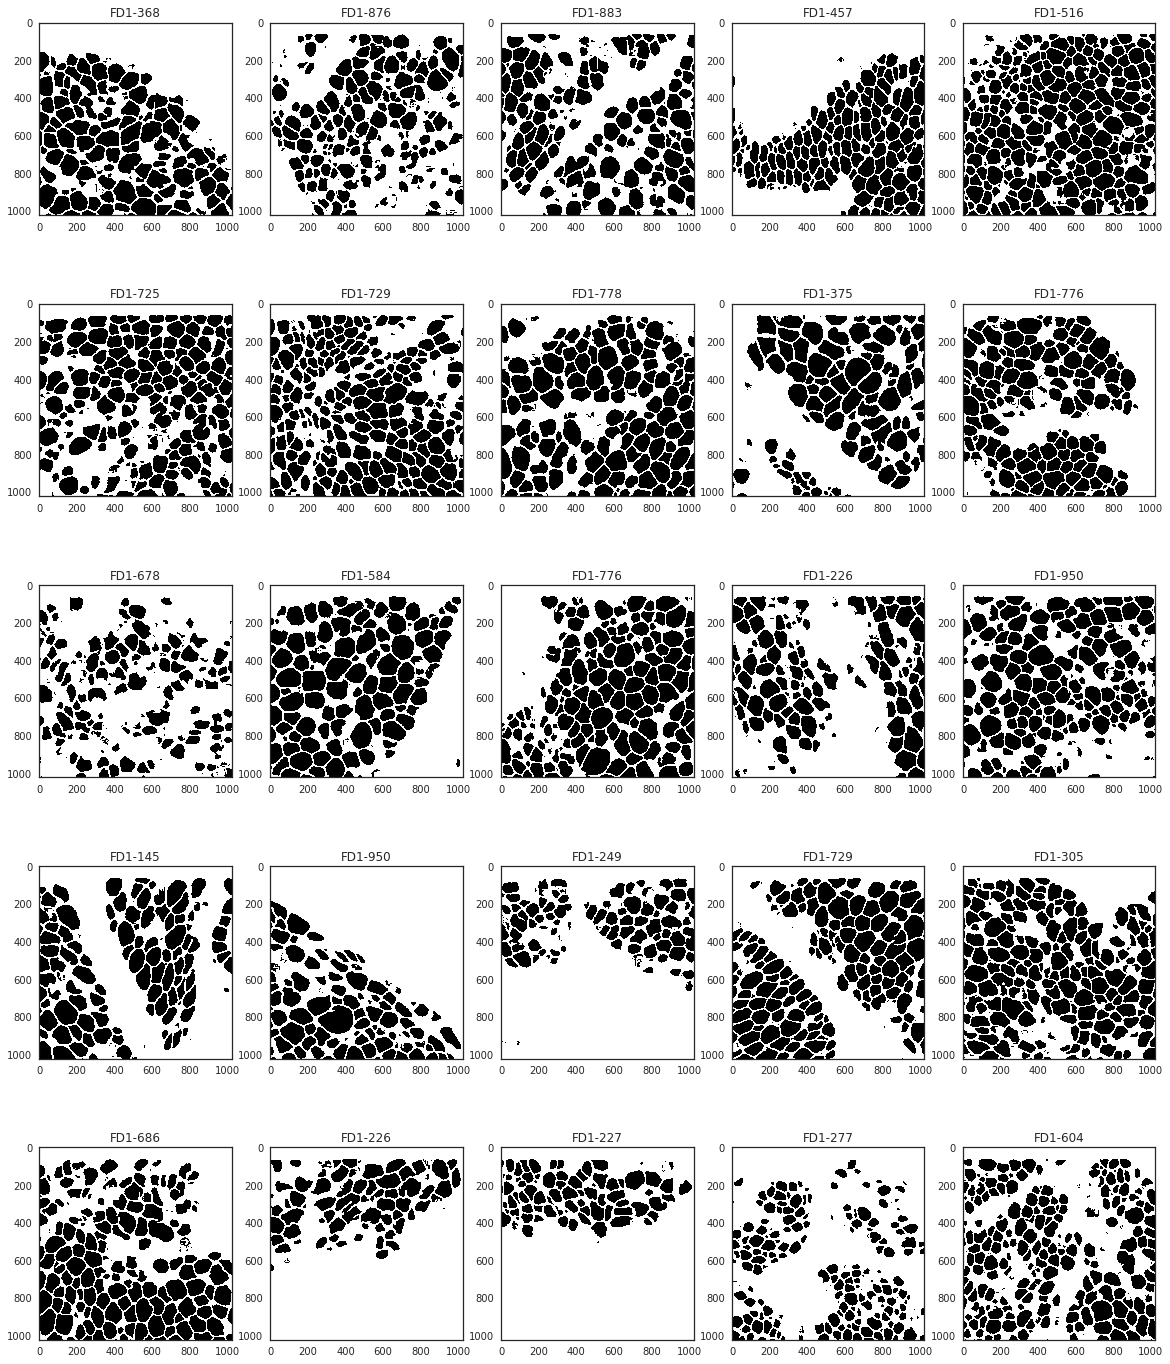

In [10]:
plot_me(list(np.random.choice(seg_masks,size=25)))

In [70]:
from tqdm import tqdm

In [12]:
#For each preproduced segmentation mask, calculate the area of all cells, the average and the count 
measurements = []
with open('exeter_areas','w') as out:
    for i in tqdm(seg_masks):
        prd_means = predict_areas(cv2.imread(i,0))
        # list of cell areas, followed by average area and count of cells.
        measurements.append(prd_means)

measurements = np.array(measurements)
np.save('exeter_measurements.npy',measurements)

100%|██████████| 4181/4181 [03:27<00:00, 20.12it/s]


In [71]:
# run the above cell previously, so we'll load in the data now.
measurements = np.load('exeter_measurements.npy')

In [72]:
len(test_tiles),len(seg_masks),len(measurements)


(4181, 4181, 4181)

In [73]:
# filter out the 1500 seg masks that have counts under 20 (0.63% of all masks)
seg_masks_filt= seg_masks
measurements_filt = measurements


In [74]:
len(seg_masks_filt),len(measurements_filt)

(4181, 4181)

In [75]:
print('Total number of cells measured in experiment: {}'.format(sum([len(a) for a in measurements_filt])))

Total number of cells measured in experiment: 477558


In [76]:
subq_mean_areas = np.array([np.mean(i) for i in measurements_filt])


In [77]:
all_areas = pd.DataFrame(
    {'mean_areas': subq_mean_areas,
     'tissue': np.repeat('Subcutaneous',len(subq_mean_areas))
    })

In [78]:
all_areas.head()

,mean_areas,tissue
0,1799.319704,Subcutaneous
1,1749.592747,Subcutaneous
2,1591.745367,Subcutaneous
3,1520.861587,Subcutaneous
4,1492.554724,Subcutaneous


In [80]:
from scipy import stats
from scipy.stats import ttest_ind as ttest

np.nanmean(all_areas['mean_areas']),np.nanstd(all_areas['mean_areas'])

#ttest(subq_mean_areas,visc_mean_areas,equal_var=False)

(1549.3120156336286, 384.1997708503372)

**Now, we need to operate at the individual sample level. So we will create a dictionary {Exeter_ID}: [areas]**

In [24]:
from collections import defaultdict

subq_samples=defaultdict(list)


In [25]:
# Some Subq samples have no tiles after this filtering.
for i,a in enumerate(subq_mean_areas):
    exeter_id = seg_masks_filt[i].split('/')[2].split('_')[0]
    try:
        if len(measurements_filt[i]) == 0:
            next
        else:
            subq_samples[exeter_id].append(measurements_filt[i])
    except KeyError:
        if len(subq_measurements_filt[i]) == 0:
            next
        else:
            subq_samples[exeter_id] = measurements_filt[i]
        
    

In [26]:
example_id = [item for sublist in subq_samples['FD1-776'] for item in sublist]
print('FD1-127 has {} tiles containing {} unique adipocyte measurements'.format(len(subq_samples['FD1-776']),len(example_id)))

FD1-127 has 104 tiles containing 13034 unique adipocyte measurements


In [27]:
# lets set a seed and do some random sampling. We want to assess how the variance changes for adipocyte
# area estimates when measuring 3, 10, 100, 500 and 1000 cells.
# A previous pulication suggests it's 100.

np.random.seed(1337)
def simulate_cells(n,data,mean=True):
    sub=[]
    for i in range(100):
        if mean == True:
            sub.append(statistics.mean(np.random.choice(data,n)))
        else:
            sub.append(statistics.stdev(np.random.choice(data,n)))
    return (sub)
    

In [28]:
three = simulate_cells(n=3,data=example_id)
ten = simulate_cells(n=10,data=example_id)
hundred = simulate_cells(n=100,data=example_id)
fivehundred = simulate_cells(n=500,data=example_id)
thousand = simulate_cells(n=1000,data=example_id)

In [29]:
simulation = pd.DataFrame(
    {'1000': thousand,
     '500': fivehundred,
     '100': hundred,
     '10':ten,
     '3': three
    })

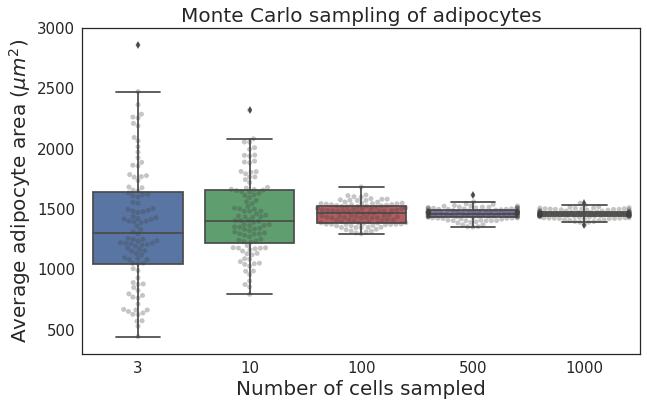

In [31]:
plt.figure(figsize=(10,6))
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
sns.set_style("white")
ax = sns.boxplot(data=simulation,order=['3','10','100','500','1000'])
ax = sns.swarmplot(data=simulation, color=".25",order=['3','10','100','500','1000'],alpha=.3)
plt.xlabel('Number of cells sampled',fontsize=20)
plt.ylabel('Average adipocyte area ($\mu m^{2}$)',fontsize=20)
plt.title('Monte Carlo sampling of adipocytes',fontsize=20)
plt.savefig('mc_sampling_exeter.pdf')

**Lets assess how many cells we have measured per sample (on average)**

In [32]:
subq_no_cells_per_sample=[]
for key,value in subq_samples.items():
    subq_no_cells_per_sample.append(len([item for sublist in subq_samples[key] for item in sublist]))

In [33]:
subq_no_tiles_per_sample=[]
for key,value in subq_samples.items():
    subq_no_tiles_per_sample.append(len([item for item in subq_samples[key]]))

In [34]:
print('Subcutaneous histology samples on average have {0:.0f} cells measured'.format(np.mean(subq_no_cells_per_sample)))

Subcutaneous histology samples on average have 3851 cells measured


In [35]:
# return the key value at the nth position in a dictionary
def ix(dic, n): 
   try:
       return list(dic)[n]
   except IndexError:
       print('not enough keys')

In [36]:
#which sample has the lowest number of adipocytes counted?
ix(dic=subq_samples,n=np.argmin(subq_no_cells_per_sample))

'FD1-273'

In [37]:
#which sample has the highest number of adipocytes counted?
ix(dic=subq_samples,n=np.argmax(subq_no_cells_per_sample))

'FD1-776'

In [38]:
# plot subcutaneous and visceral cell distributions on a single plot.
# calculate adipocyte area mean and variance.

In [39]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

**Lets plot the adipocyte area distributions for all cells across all samples:**

Text(0.5, 1.0, 'Subcutaneous')

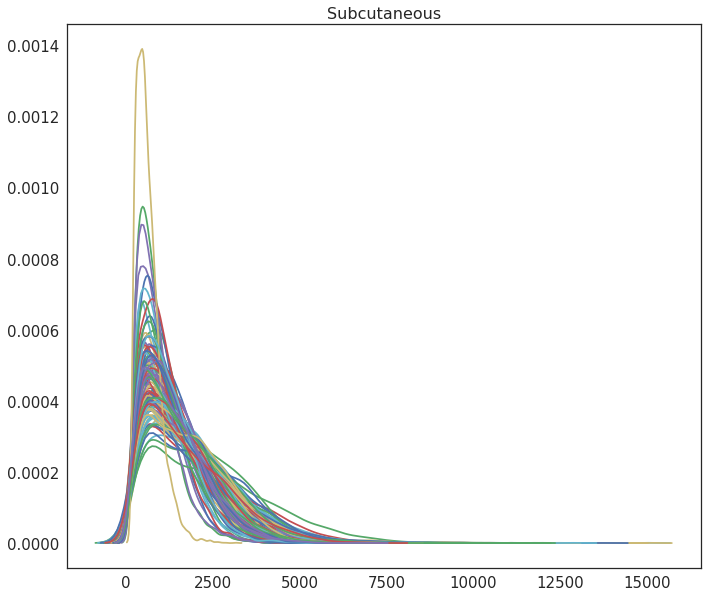

In [40]:
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,2,1)
ax.grid(b="off")
for key,value in take(125, subq_samples.items()):
    sns.distplot([item for sublist in value for item in sublist],hist=False)
plt.title('Subcutaneous',size=16)




**We will randomly select 500 cells from each sample to measure.**

In [41]:
subq_sample_areas={}

for key,value in subq_samples.items():
    tmp = [item for sublist in value for item in sublist]
    tmp = [x for x in tmp if x <= 30000]
    if len(tmp) >=500:
        selection = np.random.choice(tmp,500)
        low_std = np.mean(selection) - np.std(selection)
        high_std = np.mean(selection) + np.std(selection)
        small = sum([a < low_std for a in selection])
        large = sum([a > high_std for a in selection])
        ratio_s = small/(large+small)
        
        subq_sample_areas[key] = np.mean(selection),np.std(selection),ratio_s
    else:
        next

In [42]:
for i,v in take(10,subq_sample_areas.items()):
    print(i,v)

FD1-558 (1643.8403072, 1052.030013192015, 0.5)
FD1-637 (1131.4110463999998, 657.1812511548117, 0.50625)
FD1-728 (1600.7127039999998, 1012.5653789773025, 0.48466257668711654)
FD1-381 (1858.1504000000002, 1148.0076941978969, 0.5113636363636364)
FD1-986 (1354.2793216, 915.3344298213045, 0.48226950354609927)
FD1-396 (1629.4240256, 910.2625411141199, 0.5257142857142857)
FD1-665 (1803.718656, 1162.8704917222358, 0.49673202614379086)
FD1-375 (1642.8367872000001, 1145.7218030657034, 0.4411764705882353)
FD1-987 (1831.0094848, 1159.2942044482274, 0.5340909090909091)
FD1-188 (1742.4490496, 1246.8590356065595, 0.4258064516129032)


In [43]:
print('No of samples with 500 adipocyte areas estimated -\nSubcutaneous: {}'.format(len(subq_sample_areas)))

No of samples with 500 adipocyte areas estimated -
Subcutaneous: 124


In [44]:
# lets convert the dictionaries into dataframes so we can add and analyse additional covariates
subq_sample_area_df = pd.DataFrame(subq_sample_areas).T.rename_axis('sampleID').add_prefix('Area').reset_index()
subq_sample_area_df.columns = ['SUBJID', 'mu_area','stddev_area','per_small_cells']

In [45]:
# lets have a quick look at both the subQ table so far:
display_side_by_side(subq_sample_area_df.head())


,SUBJID,mu_area,stddev_area,per_small_cells
0,FD1-127,1919.628083,1301.718069,0.453416
1,FD1-139,2499.560243,1741.608946,0.491124
2,FD1-145,1724.139930,1089.733405,0.512658
3,FD1-158,1745.136026,1113.552157,0.512048
4,FD1-167,1794.270822,1422.084420,0.419118


In [ ]:
#subq_sample_area_df.to_csv('...')

Lets look at the distribution of mean adipocyte area across samples:

**Lets load in the Exeter sample and phenotype attributes, expand table with potentially relevant variables:**

In [48]:
import pandas as pd
phenotypes = pd.read_csv('../exeter_fATDIVA_BMI_Data.csv',delimiter=',')

In [49]:
import numpy as np
np.mean(phenotypes['Age at fATDIVA recruitment'])

58.03061224489796

In [50]:
phenotypes['SUBJID'] = ['FD1-'+str(x) for x in phenotypes['ID']]

In [51]:
subq_sample_area_df.head()

,SUBJID,mu_area,stddev_area,per_small_cells
0,FD1-127,1919.628083,1301.718069,0.453416
1,FD1-139,2499.560243,1741.608946,0.491124
2,FD1-145,1724.139930,1089.733405,0.512658
3,FD1-158,1745.136026,1113.552157,0.512048
4,FD1-167,1794.270822,1422.084420,0.419118


In [52]:
phenotypes.head()

,ID,Age at fATDIVA recruitment,GENDER,fATDIVA Ht,fATDIVA Wt,fATDIVA BMI using study Ht,Biopsy done = 1,Biopsy Pair = 1,SUBJID
0,918,38.0,F,1.71,68.12,23.30,1,1,FD1-918
1,345,37.0,F,1.58,57.81,23.16,No biopsy,NaN,FD1-345
2,263,38.0,F,1.79,77.12,24.07,1,NaN,FD1-263
3,677,54.0,F,1.64,67.83,25.22,1,1,FD1-677
4,986,54.0,F,1.72,70.05,23.68,1,NaN,FD1-986


In [53]:
subq_pheno_merged=pd.merge(subq_sample_area_df,phenotypes,left_on='SUBJID', right_on='SUBJID')

In [54]:
subq_pheno_merged.head()

,SUBJID,mu_area,stddev_area,per_small_cells,ID,Age at fATDIVA recruitment,GENDER,fATDIVA Ht,fATDIVA Wt,fATDIVA BMI using study Ht,Biopsy done = 1,Biopsy Pair = 1
0,FD1-127,1919.628083,1301.718069,0.453416,127,48.0,M,1.69,105.62,36.98,1,NaN
1,FD1-139,2499.560243,1741.608946,0.491124,139,67.0,F,1.51,94.86,41.60,1,NaN
2,FD1-145,1724.139930,1089.733405,0.512658,145,59.0,M,1.80,76.69,23.67,1,NaN
3,FD1-158,1745.136026,1113.552157,0.512048,158,53.0,F,1.59,56.43,22.32,1,NaN
4,FD1-167,1794.270822,1422.084420,0.419118,167,62.0,F,1.69,73.69,25.80,1,NaN


In [18]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression as lm_regress

In [55]:
def r_SE(x,n):
    return sqrt((float(1)-(x**2))/float(n -2))

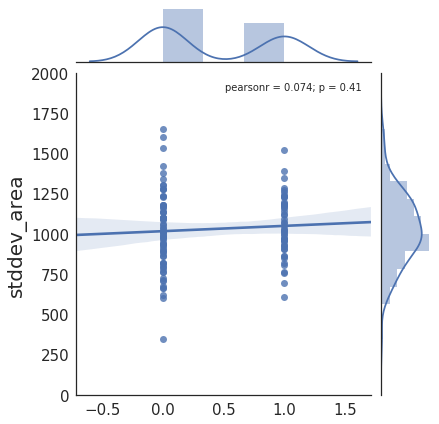

In [58]:
sns.jointplot(np.where(subq_pheno_merged['GENDER'] =='M',1,0),subq_pheno_merged['stddev_area'],kind="reg")

In [59]:
subq_pheno_merged['depot'] = np.repeat('subcutaneous',len(subq_pheno_merged))

In [60]:
len(subq_pheno_merged)

123

In [65]:
subq_pheno_merged.to_csv('Exeter_Subcutaneous_areas.csv')
len(subq_pheno_merged)

123

Subject with the lowest and highest adipocyte area variance:

In [66]:
subq_pheno_merged['SUBJID'][np.argmin(subq_pheno_merged['stddev_area'])],
subq_pheno_merged['SUBJID'][np.argmax(subq_pheno_merged['stddev_area'])]

'FD1-139'

Subject with the lowest and highest adipocyte area mean:

In [67]:
subq_pheno_merged['SUBJID'][np.argmin(subq_pheno_merged['stddev_area'])],
subq_pheno_merged['SUBJID'][np.argmax(subq_pheno_merged['stddev_area'])]

'FD1-139'

In [68]:
min_var = []
for i in seg_masks_filt:
    exeter_id = i.split('/')[2].split('_')[0]
    if exeter_id == subq_pheno_merged['SUBJID'][np.argmin(subq_pheno_merged['stddev_area'])]:
        print(i)
        min_var.append(i)
        

predicted_masks/exeter/FD1-277_29110045.JPGmask.png
predicted_masks/exeter/FD1-277_29110138.JPGmask.png
predicted_masks/exeter/FD1-277_29110149.JPGmask.png
predicted_masks/exeter/FD1-277_29110200.JPGmask.png
predicted_masks/exeter/FD1-277_29110228.JPGmask.png
predicted_masks/exeter/FD1-277_29110242.JPGmask.png
predicted_masks/exeter/FD1-277_29110254.JPGmask.png
predicted_masks/exeter/FD1-277_29110313.JPGmask.png
predicted_masks/exeter/FD1-277_29110323.JPGmask.png
predicted_masks/exeter/FD1-277_29110344.JPGmask.png
predicted_masks/exeter/FD1-277_29110349.JPGmask.png
predicted_masks/exeter/FD1-277_29110357.JPGmask.png
predicted_masks/exeter/FD1-277_29110449.JPGmask.png
predicted_masks/exeter/FD1-277_29110504.JPGmask.png
predicted_masks/exeter/FD1-277_29110517.JPGmask.png
predicted_masks/exeter/FD1-277_29110536.JPGmask.png
predicted_masks/exeter/FD1-277_29110552.JPGmask.png
predicted_masks/exeter/FD1-277_29110605.JPGmask.png
predicted_masks/exeter/FD1-277_29110635.JPGmask.png
predicted_ma

In [69]:
max_var = []
for i in seg_masks_filt:
    exeter_id = i.split('/')[2].split('_')[0]
    if exeter_id == subq_pheno_merged['SUBJID'][np.argmax(subq_pheno_merged['stddev_area'])]:
        print(i)
        max_var.append(i)
        

predicted_masks/exeter/FD1-139_23162644.JPGmask.png
predicted_masks/exeter/FD1-139_23162653.JPGmask.png
predicted_masks/exeter/FD1-139_23162719.JPGmask.png
predicted_masks/exeter/FD1-139_23162733.JPGmask.png
predicted_masks/exeter/FD1-139_23162750.JPGmask.png
predicted_masks/exeter/FD1-139_23162811.JPGmask.png
predicted_masks/exeter/FD1-139_23162817.JPGmask.png
predicted_masks/exeter/FD1-139_23162831.JPGmask.png
predicted_masks/exeter/FD1-139_23162853.JPGmask.png
predicted_masks/exeter/FD1-139_23162908.JPGmask.png
predicted_masks/exeter/FD1-139_23162933.JPGmask.png
predicted_masks/exeter/FD1-139_23162954.JPGmask.png
predicted_masks/exeter/FD1-139_23163001.JPGmask.png
predicted_masks/exeter/FD1-139_23163007.JPGmask.png
predicted_masks/exeter/FD1-139_23163013.JPGmask.png
predicted_masks/exeter/FD1-139_23163025.JPGmask.png
predicted_masks/exeter/FD1-139_23163036.JPGmask.png
predicted_masks/exeter/FD1-139_23163041.JPGmask.png
predicted_masks/exeter/FD1-139_23163103.JPGmask.png
predicted_ma

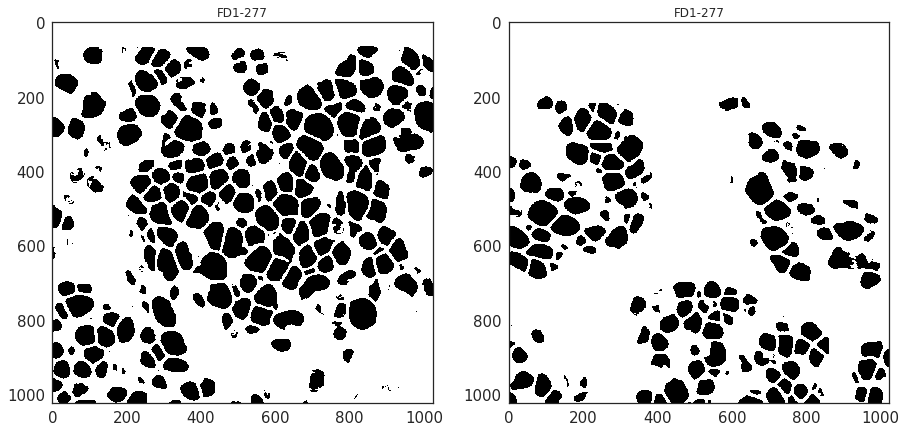

In [70]:
plot_me(min_var[0:2],x=1,y=2)

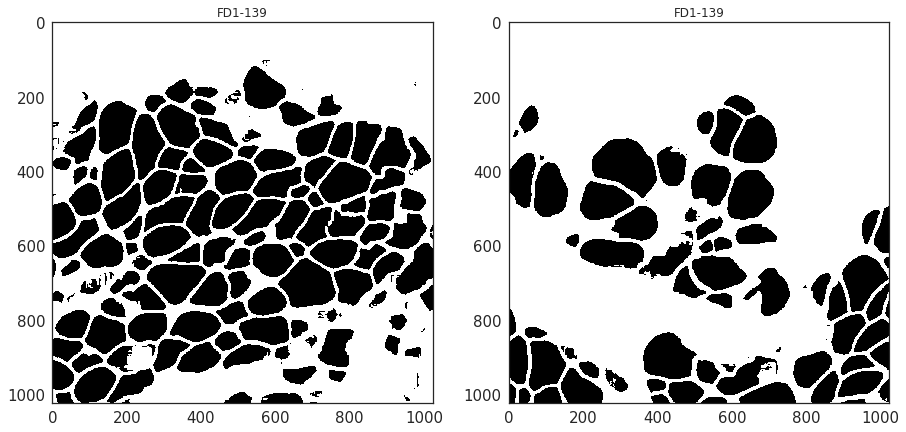

In [71]:
plot_me(max_var[0:2],x=1,y=2)

In [72]:
min_mean = []
for i in seg_masks_filt:
    exeter_id = i.split('/')[2].split('_')[0]
    if exeter_id == subq_pheno_merged['SUBJID'][np.argmin(subq_pheno_merged['mu_area'])]:
        min_mean.append(i)
        

In [73]:
max_mean = []
for i in seg_masks_filt:
    exeter_id = i.split('/')[2].split('_')[0]
    if exeter_id == subq_pheno_merged['SUBJID'][np.argmax(subq_pheno_merged['mu_area'])]:
        max_mean.append(i)
        

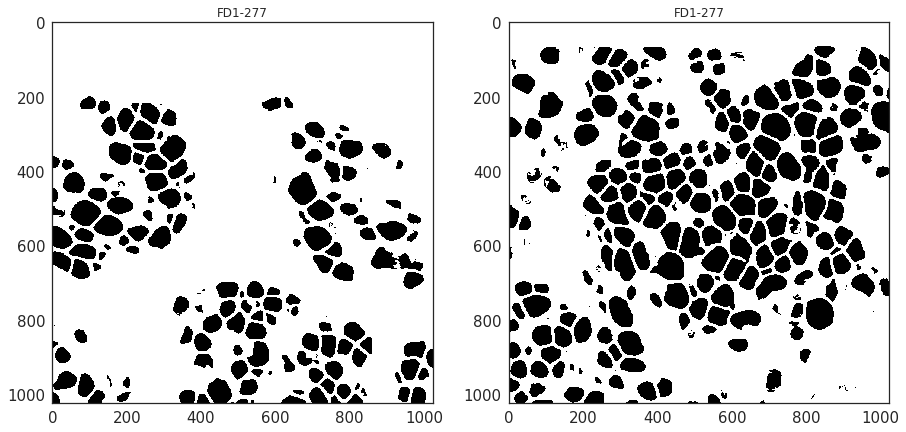

In [74]:
plot_me(min_mean[0:2],x=1,y=2)

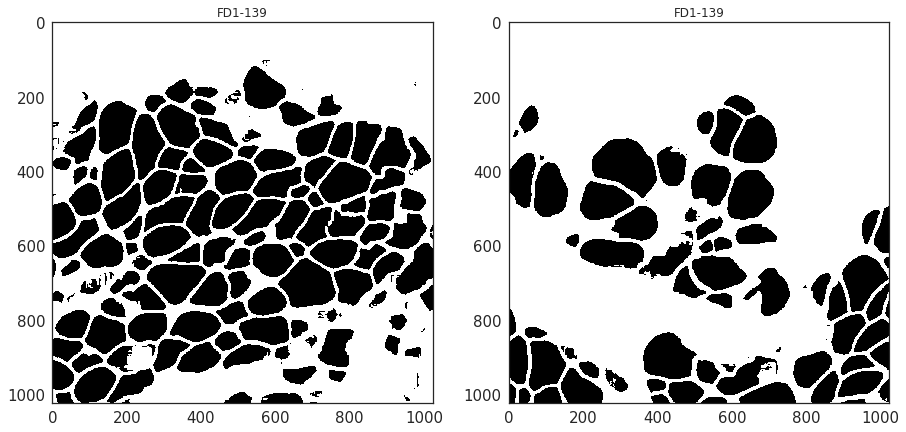

In [75]:
plot_me(max_mean[0:2],x=1,y=2)

In [15]:
subq_pheno_merged = pd.read_csv('final_cohort_measurements/Exeter_Subcutaneous_areas.csv')

Text(0, 0.5, 'Density')

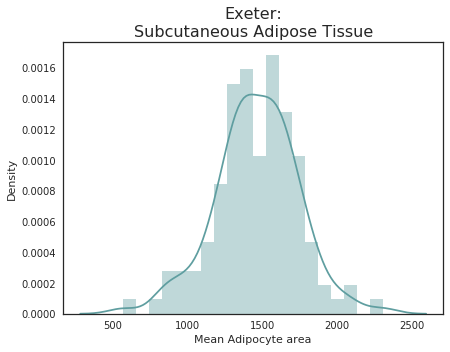

In [16]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
sns.distplot(np.array(subq_sample_area_df['mu_area'].tolist()),color='cadetblue',bins=20)
plt.title('Exeter:\nSubcutaneous Adipose Tissue',size=16)
# sns.plt.xlim(0,5000)
# sns.plt.ylim(0,0.002)
sns.plt.xlabel('Mean Adipocyte area')
sns.plt.ylabel('Density')

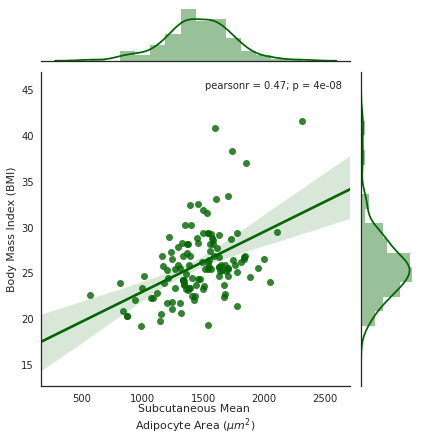

In [20]:
sns.jointplot(x=subq_pheno_merged['mu_area'],y=subq_pheno_merged['fATDIVA  BMI using study Ht'],color='darkgreen',kind='reg')
plt.xlabel('Subcutaneous Mean \nAdipocyte Area ($\mu m^{2}$)')
plt.ylabel('Body Mass Index (BMI)')
plt.savefig('exeter_bmi_subq.pdf')



In [23]:
subq_pheno_merged.head()

subq_pheno_merged['GENDER'].value_counts()

XX    71
XY    52
Name: GENDER, dtype: int64

[Text(0, 0.5, 'Mean Adipocyte Area'), Text(0.5, 0, 'Adipose Depot')]

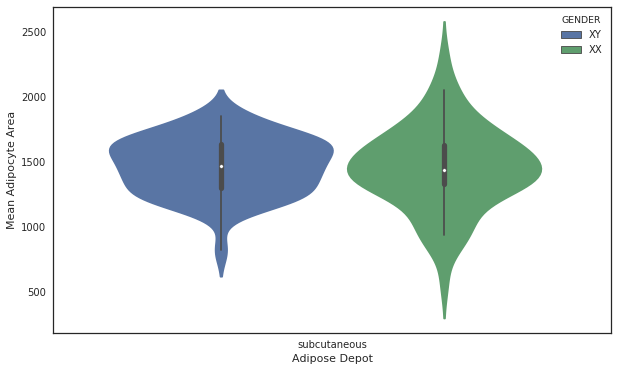

In [24]:
# by depot and sex
# both_depot_pheno['GENDER']=both_depot_pheno['sex'].astype('str')
subq_pheno_merged.GENDER.replace(['M', 'F'],['XY', 'XX'], inplace=True)
subq_pheno_merged.depot.replace([0, 1],['subcutaneous', 'visceral'], inplace=True)
fig = plt.figure(figsize=(10,6))
ax=sns.violinplot(y='mu_area',x='depot',hue='GENDER',data=subq_pheno_merged)
ax.set(xlabel="Adipose Depot", ylabel="Mean Adipocyte Area")


In [25]:
bins=[15,20,25,30,45]
subq_pheno_merged['BMI Bins'] = pd.cut(subq_pheno_merged['fATDIVA  BMI using study Ht'], bins)


[Text(0, 0.5, 'Mean Adipocyte Area'), Text(0.5, 0, 'Adipose Depot')]

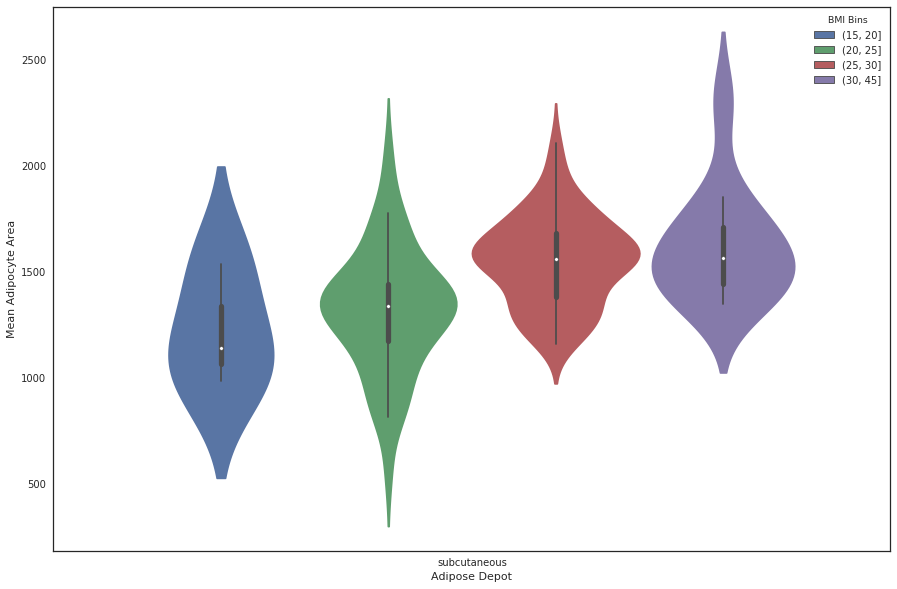

In [26]:
# by depot and sex
fig = plt.figure(figsize=(15,10))
ax=sns.violinplot(y='mu_area',x='depot',hue='BMI Bins',data=subq_pheno_merged)
ax.set(xlabel="Adipose Depot", ylabel="Mean Adipocyte Area")



In [30]:
print('The mean adipocyte areas are: \nSubcutaneous: {0:.2f}'.format(np.mean(subq_sample_area_df['mu_area'])))

The mean adipocyte areas are: 
Subcutaneous: 1460.78


In [31]:
np.std(subq_sample_area_df['mu_area'])

276.3938321937852